<style>
#myDIV {
  width: 300px;
  height: 200px;
  background: red;
  animation: mymove 5s infinite;
}

@keyframes mymove {
  from {background-color: red;}
  to {background-color: blue;}
}
</style>
<div id="myDIV" style="background-color: black;color:white; padding: 10px 10px 10px 10px;"><p>This kernel is a work in progress. If you like my work, be sure to upvote this kernel so it looks more relevant and meaningful to the community.</p></div>

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import plot_model
from sklearn.metrics import classification_report
from collections import Counter
import tensorflow as tf

import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Number of images in the train set :  14034
Number of images in the test set ;  3000
Number of images in prediction set :  7301


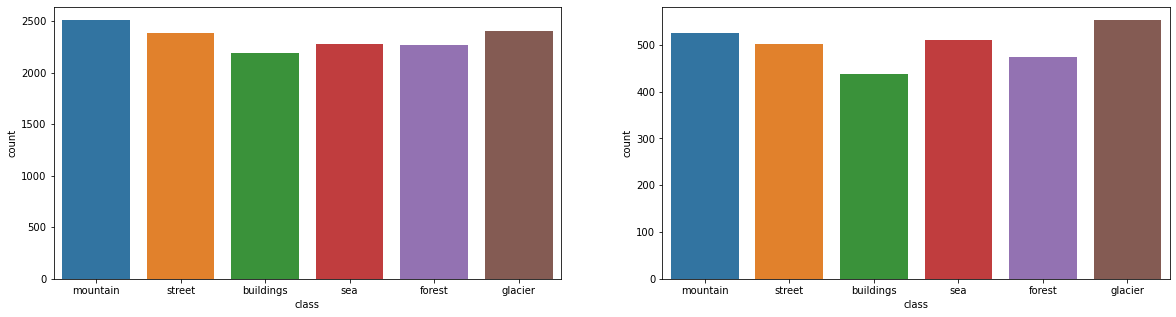

In [3]:
root_path = '/kaggle/input/intel-image-classification/'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = os.listdir(os.path.join(root_path,train_pred_test_folders[0],train_pred_test_folders[0])) #one more seg_train folder within
seg_pred_folders = os.listdir(os.path.join(root_path,train_pred_test_folders[1],train_pred_test_folders[1]))
seg_test_folders = os.listdir(os.path.join(root_path,train_pred_test_folders[2],train_pred_test_folders[2]))
quantity_tr = {} 
quantity_te = {}
for folder in seg_train_folders:
    quantity_tr[folder] = len(os.listdir(os.path.join(root_path,train_pred_test_folders[0],train_pred_test_folders[0],folder)))

for folder in seg_test_folders:
    quantity_te[folder] = len(os.listdir(os.path.join(root_path,train_pred_test_folders[2],train_pred_test_folders[2],folder)))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(os.path.join(root_path,train_pred_test_folders[1],train_pred_test_folders[1])))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

In [4]:
def save_history(history, model_name):
    #convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = model_name+'_history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)

    # or save to csv: 
    hist_csv_file = model_name+'_history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
        
def plot_accuracy_from_history(history):
    color = sns.color_palette()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    

    epochs = range(len(acc))

    sns.lineplot(epochs, acc, label='Training Accuracy')
    sns.lineplot(epochs, val_acc,label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.figure()
    plt.show()
    
def plot_loss_from_history(history):
    color = sns.color_palette()
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    sns.lineplot(epochs, loss,label='Training Loss')
    sns.lineplot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.figure()
    plt.show()
                   
        

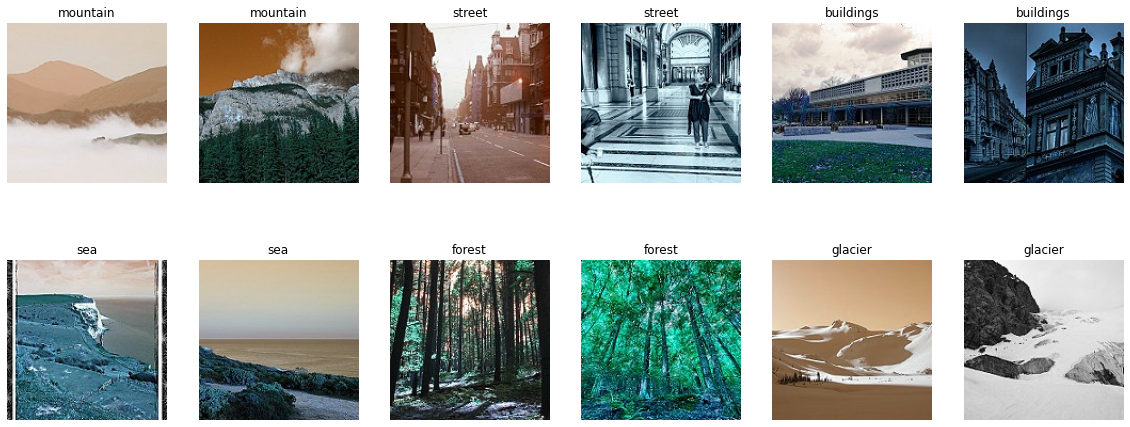

In [5]:
number_of_examples = 2
figure1, ax1 = plt.subplots(number_of_examples,len(seg_train_folders), figsize=(20,4*number_of_examples))
ax1 = ax1.reshape(-1)
axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
axoff_fun(ax1)
axs = 0
for i, folder in enumerate(seg_train_folders):
    image_ids = os.listdir(os.path.join(root_path,train_pred_test_folders[0],train_pred_test_folders[0],folder))[0:number_of_examples]
    for j, img in enumerate(image_ids):
        img_path = os.path.join(root_path,train_pred_test_folders[0],train_pred_test_folders[0],folder,img)
        display = cv2.imread(img_path)
        plt.axis('off')
        ax1[axs].imshow(display)
        ax1[axs].set_title(folder)
        axs=axs+1

In [6]:
train_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train/"

train_datagen = ImageDataGenerator( rescale = 1.0/255,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 14034 images belonging to 6 classes.


In [7]:
test_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_DIR, batch_size=32, class_mode='categorical', target_size=(150, 150))

Found 3000 images belonging to 6 classes.


In [8]:
print(validation_generator.class_indices)
inv_map_classes = {v: k for k, v in validation_generator.class_indices.items()}
print(inv_map_classes)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [9]:
tf.keras.backend.clear_session()

In [9]:
#random architecture
benchmark_model = Sequential()

# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=(150,150,3)))
#Outputs 128 * (32* Image(150x150) * 3 ) and is the input for the next filter which performs 128 more filter convolutions
# Since the kernel size is 5, we will end up with an each image being 146 pixels on each side i.e., 146x146
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))

benchmark_model.add(Conv2D(32, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))

benchmark_model.add(Flatten())
benchmark_model.add(Dense(64,activation='relu'))
benchmark_model.add(Dense(6,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 32)        51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 34848)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2230336   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

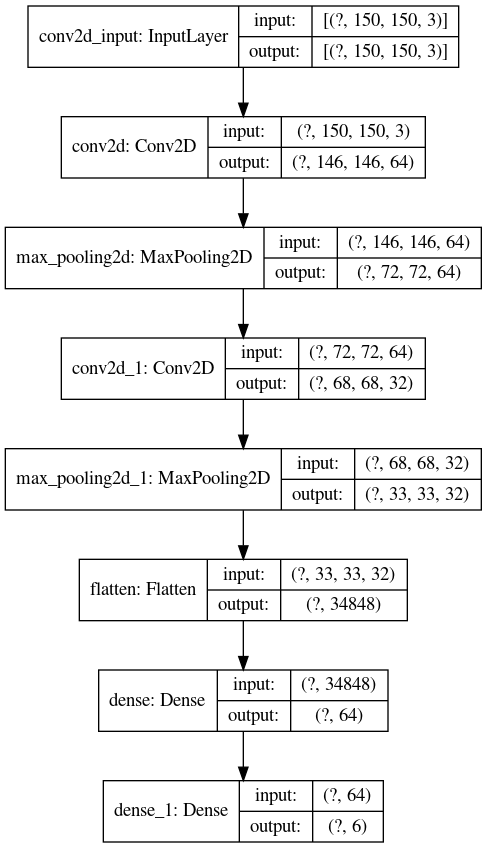

In [10]:
plot_model(benchmark_model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [11]:
filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator,epochs=10, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint])


439/439 [==============================] - ETA: 0s - loss: 1.2018 - acc: 0.5168
Epoch 00001: val_acc improved from -inf to 0.61267, saving model to bench_mark_-model-01-0.61.hdf5
439/439 [==============================] - 735s 2s/step - loss: 1.2018 - acc: 0.5168 - val_loss: 1.0033 - val_acc: 0.6127


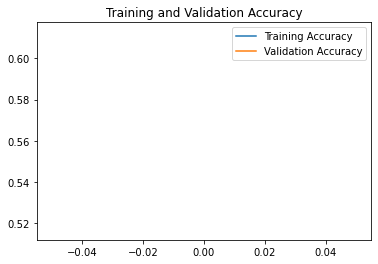

<Figure size 432x288 with 0 Axes>

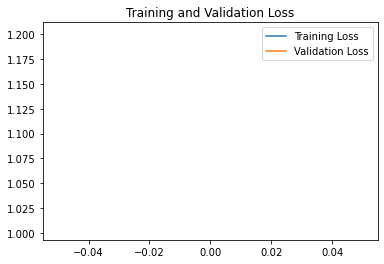

<Figure size 432x288 with 0 Axes>

In [12]:
save_history(history, 'benchmark_model')
benchmark_model.save(filepath)
plot_accuracy_from_history(history)
plot_loss_from_history(history)

In [14]:
true_value = []
benchmark_model_pred = []

for folder in seg_test_folders:
    
    test_image_ids = os.listdir(os.path.join(root_path,train_pred_test_folders[2],train_pred_test_folders[2],folder))
    
    for image_id in test_image_ids:
        
        path = os.path.join(root_path,train_pred_test_folders[2],train_pred_test_folders[2],folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        benchmark_image_prediction = np.argmax(benchmark_model.predict(np.array([img])))                               
        benchmark_model_pred.append(benchmark_image_prediction)

In [15]:
correct_prediction_count = [true_value[i] == benchmark_model_pred[i] for i in range(len(true_value))]
combined_model_accuracy = np.sum(correct_prediction_count)/len(correct_prediction_count)
print('Benchmark Model Accuracy', combined_model_accuracy)

print(classification_report(true_value,benchmark_model_pred, target_names = list(validation_generator.class_indices.keys())))

Benchmark Model Accuracy 0.43
              precision    recall  f1-score   support

   buildings       0.29      0.48      0.36       437
      forest       0.87      0.59      0.70       474
     glacier       0.34      0.48      0.39       553
    mountain       0.61      0.09      0.15       525
         sea       0.53      0.11      0.18       510
      street       0.44      0.87      0.58       501

    accuracy                           0.43      3000
   macro avg       0.51      0.44      0.40      3000
weighted avg       0.51      0.43      0.39      3000



In [16]:
train_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train/"

train_datagen = ImageDataGenerator( rescale = 1.0/255,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

test_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_DIR, batch_size=32, class_mode='categorical', target_size=(150, 150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [17]:
number_of_epochs = 40

### VGG16

58892288/58889256 [==============================] - 1s 0us/step


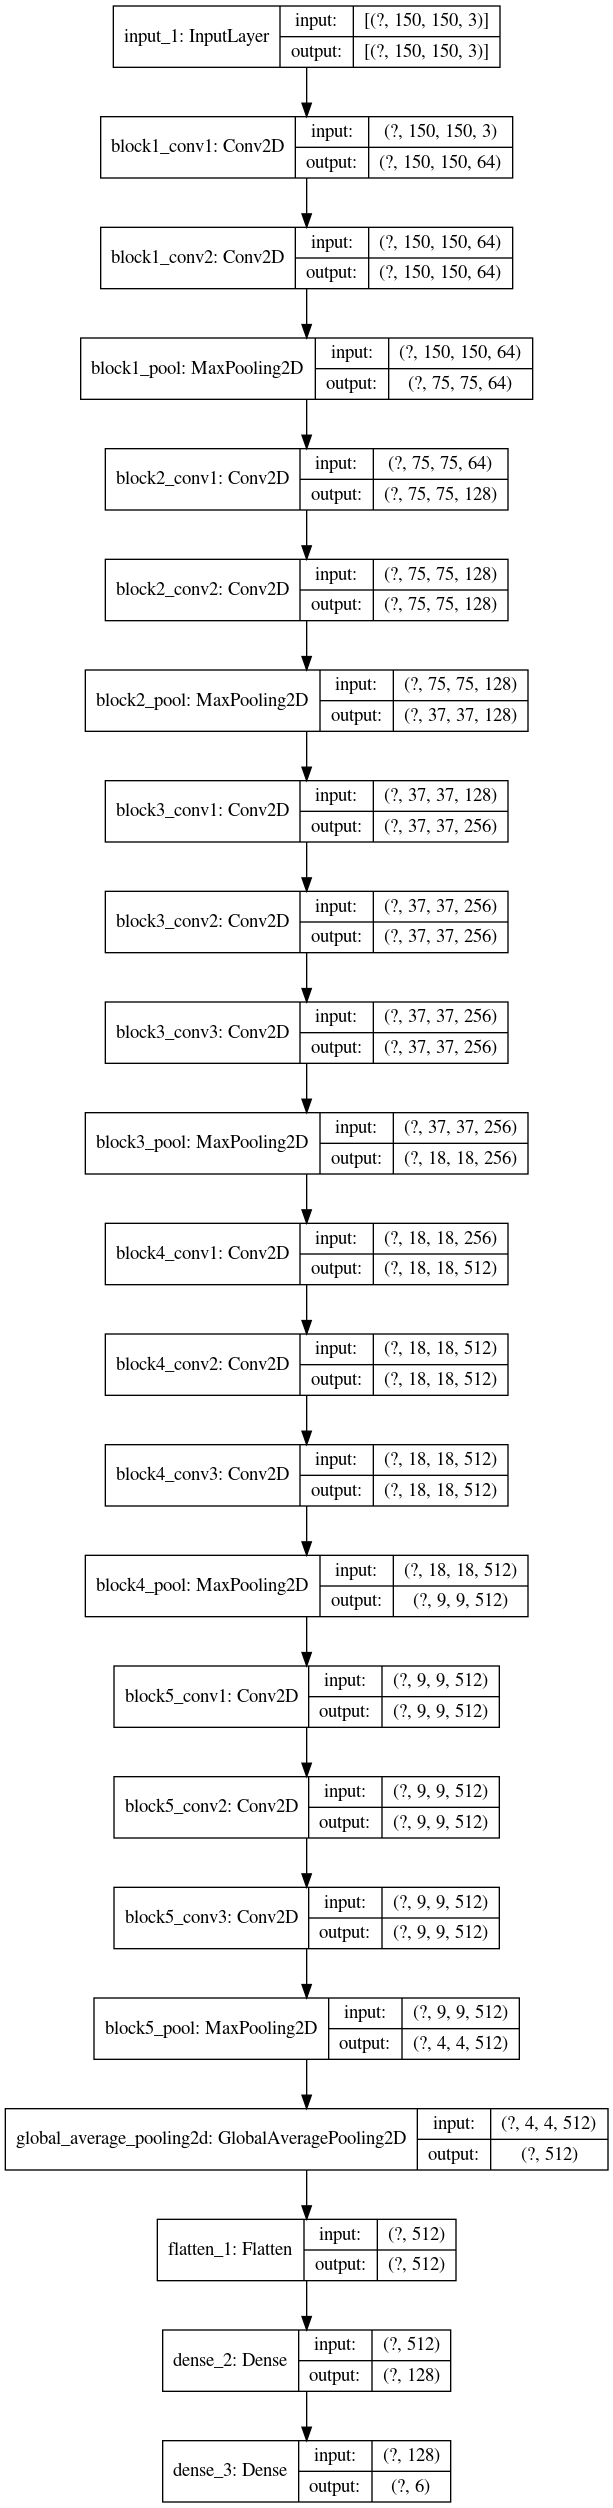

In [18]:
filepath = "vgg16_saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))

last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(6, activation = 'softmax')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
plot_model(vgg16_final_model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [ ]:
# VGG16
vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'

vgg_checkpoint = tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

vgg_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

vgg16_history = vgg16_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[vgg_checkpoint,vgg_early_stopping],verbose=1)

save_history(vgg16_history, 'vgg16_model')
plot_accuracy_from_history(vgg16_history)
plot_loss_from_history(vgg16_history)

### RESNET50

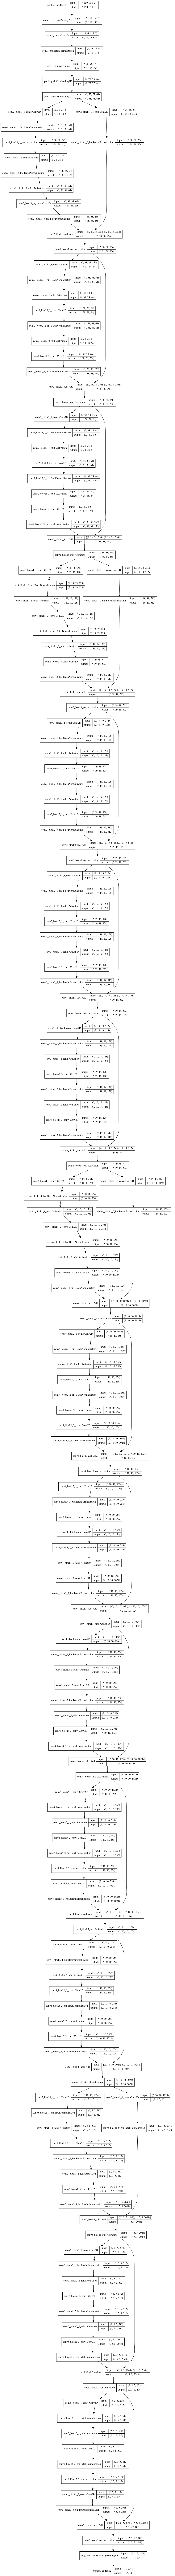

In [19]:
input_tensor = Input(shape=(150, 150, 3))
ResNet50_model = ResNet50(weights=None,classes=6, include_top=True,input_tensor=input_tensor, input_shape=(150,150,3))
res_last_output = ResNet50_model.layers[-1].output
resnet50_x = Dense(units = 128, activation = 'relu')(res_last_output)
resnet50_x = Dense(6, activation = 'softmax')(resnet50_x)

resnet50_x_final_model = Model(ResNet50_model.input, resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
plot_model(ResNet50_model, to_file='model.png',show_shapes=True, show_layer_names=True)

439/439 [==============================] - ETA: 0s - loss: 1.6313 - acc: 0.2852
Epoch 00001: val_acc improved from -inf to 0.20833, saving model to resnet50_-saved-model-01-acc-0.21.hdf5
439/439 [==============================] - 2850s 6s/step - loss: 1.6313 - acc: 0.2852 - val_loss: 1.9069 - val_acc: 0.2083


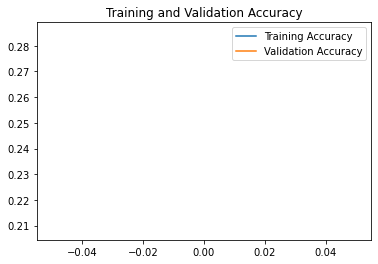

<Figure size 432x288 with 0 Axes>

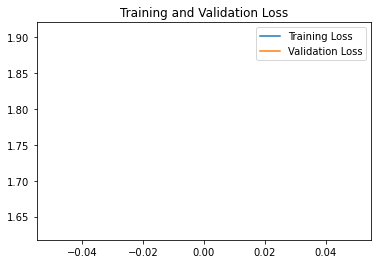

<Figure size 432x288 with 0 Axes>

In [21]:
resnet_filepath = 'resnet50_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'

resnet_checkpoint = tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

resnet_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

resnet50_history = resnet50_x_final_model.fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[resnet_checkpoint,resnet_early_stopping],verbose=1)

save_history(resnet50_history, 'resnet50_model')
plot_accuracy_from_history(resnet50_history)
plot_loss_from_history(resnet50_history)

### INCEPTIONV3

In [22]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(150, 150, 3))

InceptionV3_model = InceptionV3(input_tensor=None, input_shape=(150,150,3),weights=None, include_top=True, classes=6)
InceptionV3_last_output = InceptionV3_model.layers[-1].output
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_last_output)
# and a logistic layer -- let's say we have 200 classes
InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(InceptionV3_model.input, InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
plot_model(InceptionV3_x_final_model, to_file='model.png',show_shapes=True, show_layer_names=True)

439/439 [==============================] - ETA: 0s - loss: 1.5519
Epoch 00001: val_loss improved from -inf to 1.38160, saving model to inceptionv3_-saved-model-01-loss-1.55.hdf5
439/439 [==============================] - 1545s 4s/step - loss: 1.5519 - val_loss: 1.3816


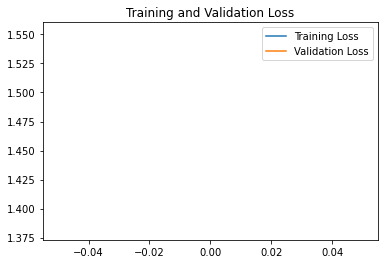

<Figure size 432x288 with 0 Axes>

In [23]:
inception_filepath = 'inceptionv3_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'

inception_checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, verbose=1, save_best_only=True, mode='max')

inception_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

inceptionv3_history = InceptionV3_x_final_model.fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[inception_checkpoint,inception_early_stopping],verbose=1)

save_history(inceptionv3_history, 'inceptionv3_model')
# we don't have accuracy information for inceptionv3
#plot_accuracy_from_history(inceptionv3_history)
plot_loss_from_history(inceptionv3_history)    

### Combining the best models of VGG16, Resnet50 & InceptionV3

In [10]:


#vgg_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/vgg_16_-saved-model-24-acc-0.89.hdf5')
#resnet_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/resnet50_-saved-model-09-0.17.hdf5')
#inception_best_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/inception_-saved-model-06-1.88.hdf5')

vgg_best_model = vgg16_final_model 
resnet_best_model = resnet50_x_final_model
inception_best_model = InceptionV3_x_final_model 

In [11]:
test_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_DIR, batch_size=1, class_mode='categorical', target_size=(150, 150))

Found 3000 images belonging to 6 classes.


In [12]:

def mode(my_list):
    ct = Counter(my_list)
    max_value = max(ct.values())
    return sorted(key for key, value in ct.items() if value == max_value)

true_value = []
combined_model_pred = []

for folder in seg_test_folders:
    
    test_image_ids = os.listdir(os.path.join(root_path,train_pred_test_folders[2],train_pred_test_folders[2],folder))
    
    for image_id in test_image_ids:
        
        path = os.path.join(root_path,train_pred_test_folders[2],train_pred_test_folders[2],folder,image_id)
        
        true_value.append(validation_generator.class_indices[folder])
        img = cv2.resize(cv2.imread(path),(150,150))
        inception_image_prediction = np.argmax(inception_best_model.predict(np.array([img])))
        vgg16_image_prediction = np.argmax(vgg_best_model.predict(np.array([img])))
        resnet_50_image_prediction = np.argmax(resnet_best_model.predict(np.array([img])))
        #giving vgg16 high priority if they all predict something different
        image_prediction = mode([vgg16_image_prediction, resnet_50_image_prediction, inception_image_prediction])                                  
        combined_model_pred.append(image_prediction)

In [15]:
combined_model_pred = [ c[0] for c in combined_model_pred]
correct_prediction_count = [true_value[i] == combined_model_pred[i] for i in range(len(true_value))]
combined_model_accuracy = np.sum(correct_prediction_count)/len(correct_prediction_count)
print('Combined Model Accuracy', combined_model_accuracy)

print(classification_report(true_value,combined_model_pred, target_names = list(validation_generator.class_indices.keys())))

Combined Model Accuracy 0.18266666666666667
              precision    recall  f1-score   support

   buildings       0.15      1.00      0.26       437
      forest       0.00      0.00      0.00       474
     glacier       0.00      0.00      0.00       553
    mountain       0.85      0.21      0.34       525
         sea       0.00      0.00      0.00       510
      street       0.00      0.00      0.00       501

    accuracy                           0.18      3000
   macro avg       0.17      0.20      0.10      3000
weighted avg       0.17      0.18      0.10      3000



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
